In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test (8)/test.csv
/kaggle/input/facial-keypoints-detection/training/training.csv


In [2]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Activation,Convolution2D,MaxPool2D
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
import cv2
%matplotlib inline

Using TensorFlow backend.


In [3]:
train = pd.read_csv('../input/facial-keypoints-detection/training/training.csv')
test = pd.read_csv('../input/facial-keypoints-detection/test (8)/test.csv')

In [4]:
train['Image'] =train['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [5]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [6]:
temp=train

In [7]:
train=temp
train=train.fillna(method='ffill')
train.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,...,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000
mean,66.358588,37.649140,30.306631,37.975901,59.224060,36.675731,73.746775,35.619961,37.214171,38.942849,...,48.374186,62.715884,69.586932,73.195985,33.799680,76.964546,50.425299,74.982529,48.565976,78.979256
std,3.447098,3.152072,3.083087,3.032590,1.537961,1.581946,1.961901,2.184829,1.393110,1.470456,...,4.280038,5.720567,4.932241,3.242852,2.350229,2.578721,2.543271,3.294983,4.266848,5.406621
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082643,35.900605,28.782316,36.327178,59.255347,36.065143,73.942694,34.624653,37.478531,39.355685,...,46.602370,59.292697,65.731401,71.862041,34.232759,77.339429,49.471414,75.963592,46.571821,75.553726
50%,66.493907,37.526919,30.253135,37.812736,59.255347,36.065143,73.942694,34.624653,37.478531,39.398041,...,48.424713,63.451421,72.600433,71.862041,34.232759,77.339429,51.599453,75.963592,48.588662,78.704640
75%,68.024628,39.254400,31.768407,39.565928,59.255347,36.499692,73.942694,35.902613,37.478531,39.398041,...,50.330437,66.492686,72.600433,72.591200,34.232759,77.339429,51.599453,75.963592,50.676559,82.236528
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [8]:
test['Image'] =test['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [9]:
test['Image'][0].shape

(96, 96)

In [10]:
train['Image']

0       [[238, 236, 237, 238, 240, 240, 239, 241, 241,...
1       [[219, 215, 204, 196, 204, 211, 212, 200, 180,...
2       [[144, 142, 159, 180, 188, 188, 184, 180, 167,...
3       [[193, 192, 193, 194, 194, 194, 193, 192, 168,...
4       [[147, 148, 160, 196, 215, 214, 216, 217, 219,...
                              ...                        
7044    [[71, 74, 85, 105, 116, 128, 139, 150, 170, 18...
7045    [[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, ...
7046    [[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, ...
7047    [[254, 254, 254, 254, 254, 238, 193, 145, 121,...
7048    [[53, 62, 67, 76, 86, 91, 97, 105, 105, 106, 1...
Name: Image, Length: 7049, dtype: object

In [11]:
x_train = np.asarray([train['Image']], dtype=np.uint8).reshape(train.shape[0],96,96,1)
y_train = train.drop(['Image'], axis=1)

In [12]:
x_train.shape,y_train.shape

((7049, 96, 96, 1), (7049, 30))

In [13]:
type(x_train),type(y_train)

(numpy.ndarray, pandas.core.frame.DataFrame)

In [14]:
y_train=y_train.to_numpy()
type(y_train)

numpy.ndarray

In [15]:
def get_dots(df,idx):
    plt.imshow(df['Image'][idx],cmap='gray')
    for i in range(1,31,2):
        plt.plot(df.loc[idx][i-1],df.loc[idx][i],'ro')
    

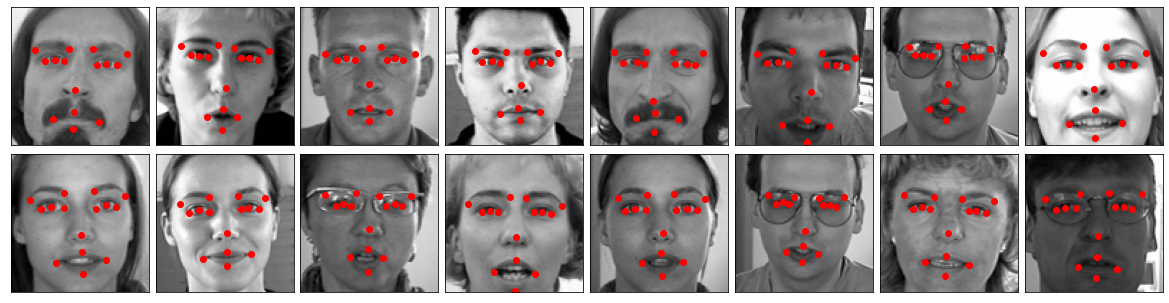

In [16]:
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(2, 8, i + 1, xticks=[], yticks=[])
    get_dots(train, i)

plt.show()

In [17]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)       

In [18]:
model.compile(optimizer='adam', loss='mse', metrics=['mae','accuracy'])

In [19]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [20]:
# model.fit(x_train, y_train, epochs=2)

In [24]:
history=model.fit(x_train,y_train,epochs=500,batch_size=128,validation_data=(x_dev,y_dev))

Train on 6344 samples, validate on 705 samples
Epoch 1/500
6344/6344 [==============================] - 6s 907us/step - loss: 20.5567 - mae: 3.4683 - accuracy: 0.4207 - val_loss: 31.4576 - val_mae: 4.7233 - val_accuracy: 0.6426
Epoch 2/500
6344/6344 [==============================] - 6s 906us/step - loss: 17.2472 - mae: 3.1585 - accuracy: 0.4792 - val_loss: 37.0363 - val_mae: 5.1986 - val_accuracy: 0.6468
Epoch 3/500
6344/6344 [==============================] - 6s 903us/step - loss: 15.3224 - mae: 2.9712 - accuracy: 0.5654 - val_loss: 14.8650 - val_mae: 3.0099 - val_accuracy: 0.7532
Epoch 4/500
6344/6344 [==============================] - 6s 905us/step - loss: 13.9616 - mae: 2.8323 - accuracy: 0.5891 - val_loss: 12.0181 - val_mae: 2.5885 - val_accuracy: 0.7816
Epoch 5/500
6344/6344 [==============================] - 6s 899us/step - loss: 12.3969 - mae: 2.6610 - accuracy: 0.6160 - val_loss: 9.1139 - val_mae: 2.0458 - val_accuracy: 0.7475
Epoch 6/500
6344/6344 [==========================

6344/6344 [==============================] - 6s 902us/step - loss: 3.5712 - mae: 1.4118 - accuracy: 0.8731 - val_loss: 4.6930 - val_mae: 1.1750 - val_accuracy: 0.8000
Epoch 92/500
6344/6344 [==============================] - 6s 919us/step - loss: 2.8755 - mae: 1.2566 - accuracy: 0.8709 - val_loss: 4.6622 - val_mae: 1.1473 - val_accuracy: 0.8043
Epoch 93/500
6344/6344 [==============================] - 6s 917us/step - loss: 2.8640 - mae: 1.2497 - accuracy: 0.8816 - val_loss: 4.7819 - val_mae: 1.0544 - val_accuracy: 0.7560
Epoch 94/500
6344/6344 [==============================] - 6s 909us/step - loss: 3.0087 - mae: 1.2889 - accuracy: 0.8804 - val_loss: 4.9445 - val_mae: 1.1910 - val_accuracy: 0.8298
Epoch 95/500
6344/6344 [==============================] - 6s 903us/step - loss: 2.7474 - mae: 1.2273 - accuracy: 0.8845 - val_loss: 4.3597 - val_mae: 0.9896 - val_accuracy: 0.7702
Epoch 96/500
6344/6344 [==============================] - 6s 906us/step - loss: 2.9559 - mae: 1.2694 - accuracy: 

6344/6344 [==============================] - 6s 902us/step - loss: 2.6064 - mae: 1.2036 - accuracy: 0.9076 - val_loss: 4.0446 - val_mae: 0.9722 - val_accuracy: 0.8156
Epoch 182/500
6344/6344 [==============================] - 6s 901us/step - loss: 2.4419 - mae: 1.1587 - accuracy: 0.9021 - val_loss: 3.8348 - val_mae: 0.8197 - val_accuracy: 0.8156
Epoch 183/500
6344/6344 [==============================] - 6s 894us/step - loss: 2.6197 - mae: 1.2016 - accuracy: 0.9027 - val_loss: 4.2066 - val_mae: 0.9335 - val_accuracy: 0.8241
Epoch 184/500
6344/6344 [==============================] - 6s 905us/step - loss: 2.9478 - mae: 1.2815 - accuracy: 0.8955 - val_loss: 4.2318 - val_mae: 0.9788 - val_accuracy: 0.8284
Epoch 185/500
6344/6344 [==============================] - 6s 897us/step - loss: 2.7562 - mae: 1.2353 - accuracy: 0.8968 - val_loss: 4.1749 - val_mae: 1.0484 - val_accuracy: 0.8241
Epoch 186/500
6344/6344 [==============================] - 6s 919us/step - loss: 2.6243 - mae: 1.2035 - accur

6344/6344 [==============================] - 6s 917us/step - loss: 2.4283 - mae: 1.1666 - accuracy: 0.9038 - val_loss: 4.1841 - val_mae: 1.0207 - val_accuracy: 0.8326
Epoch 272/500
6344/6344 [==============================] - 6s 898us/step - loss: 2.4457 - mae: 1.1679 - accuracy: 0.9081 - val_loss: 3.9860 - val_mae: 0.8429 - val_accuracy: 0.8426
Epoch 273/500
6344/6344 [==============================] - 6s 891us/step - loss: 2.4364 - mae: 1.1643 - accuracy: 0.9026 - val_loss: 4.1650 - val_mae: 0.8828 - val_accuracy: 0.8128
Epoch 274/500
6344/6344 [==============================] - 6s 895us/step - loss: 2.3226 - mae: 1.1323 - accuracy: 0.9095 - val_loss: 4.0962 - val_mae: 0.9802 - val_accuracy: 0.8326
Epoch 275/500
6344/6344 [==============================] - 6s 890us/step - loss: 2.3028 - mae: 1.1185 - accuracy: 0.9049 - val_loss: 4.0659 - val_mae: 1.0266 - val_accuracy: 0.8170
Epoch 276/500
6344/6344 [==============================] - 6s 895us/step - loss: 2.7417 - mae: 1.2365 - accur

6344/6344 [==============================] - 6s 892us/step - loss: 2.1740 - mae: 1.0933 - accuracy: 0.9094 - val_loss: 4.0032 - val_mae: 0.9009 - val_accuracy: 0.8227
Epoch 362/500
6344/6344 [==============================] - 6s 891us/step - loss: 2.2990 - mae: 1.1306 - accuracy: 0.9157 - val_loss: 4.0338 - val_mae: 0.8387 - val_accuracy: 0.8411
Epoch 363/500
6344/6344 [==============================] - 6s 901us/step - loss: 2.6554 - mae: 1.2269 - accuracy: 0.9111 - val_loss: 5.5112 - val_mae: 1.5408 - val_accuracy: 0.8411
Epoch 364/500
6344/6344 [==============================] - 6s 895us/step - loss: 2.7314 - mae: 1.2497 - accuracy: 0.9072 - val_loss: 3.8376 - val_mae: 0.8195 - val_accuracy: 0.8411
Epoch 365/500
6344/6344 [==============================] - 6s 905us/step - loss: 2.4349 - mae: 1.1695 - accuracy: 0.9042 - val_loss: 4.1446 - val_mae: 0.9476 - val_accuracy: 0.8184
Epoch 366/500
6344/6344 [==============================] - 6s 897us/step - loss: 2.2566 - mae: 1.1123 - accur

6344/6344 [==============================] - 6s 896us/step - loss: 2.3809 - mae: 1.1543 - accuracy: 0.9133 - val_loss: 4.2287 - val_mae: 1.1189 - val_accuracy: 0.8298
Epoch 452/500
6344/6344 [==============================] - 6s 894us/step - loss: 2.1441 - mae: 1.0805 - accuracy: 0.9160 - val_loss: 3.7662 - val_mae: 0.7971 - val_accuracy: 0.8170
Epoch 453/500
6344/6344 [==============================] - 6s 889us/step - loss: 2.3077 - mae: 1.1280 - accuracy: 0.9049 - val_loss: 3.7472 - val_mae: 0.7881 - val_accuracy: 0.8170
Epoch 454/500
6344/6344 [==============================] - 6s 898us/step - loss: 2.3286 - mae: 1.1429 - accuracy: 0.9083 - val_loss: 3.9192 - val_mae: 0.9103 - val_accuracy: 0.8113
Epoch 455/500
6344/6344 [==============================] - 6s 888us/step - loss: 2.1193 - mae: 1.0837 - accuracy: 0.9119 - val_loss: 4.2014 - val_mae: 1.0362 - val_accuracy: 0.8397
Epoch 456/500
6344/6344 [==============================] - 6s 895us/step - loss: 2.3302 - mae: 1.1363 - accur

In [28]:
score=model.evaluate(x_dev,y_dev)


705/705 [==============================] - 0s 418us/step


In [25]:
model.save("model.h5")

In [30]:
score

[3.7799484296682033, 0.7993033528327942, 0.8269503712654114]

In [33]:
x_test = np.asarray([test['Image']], dtype=np.uint8).reshape(test.shape[0],96,96,1)


In [35]:
y_test_predict=model.predict(x_test)

In [36]:
n=11
te=x_test[n].reshape((96,96))
plt.imshow(te,cmap='gray')
for i in range(1,31,2):
    plt.plot(y_test_predict[n][i-1],y_test_predict[n][i],'ro')
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'imshhow'